# <center>Customer Lifetime Value (CLTV / CLV)</center>
---

Companies uses this as a metric to **extract profitability** and to **focus on which customers**. In simple words CLTV is **profit estimated** from the future relationship with customer. 

There are various approaches for **modelling CLTV**.
1. **Econometric approach**
2. **Machine Learning approach**
    * **Step 1:** `Subset a Cohort` - a **cohort** is a group of customers that all start at the same time.
    
    * **Step 2:** `Temporal Splitting` - splitting by time.
    
    * **Step 3:** `RFM feature engineering` - extracting **Recency, Frequency, Monetary (RFM)** features.
    
    * **Step 4:** `Predict 2 models` - Regression Model & Classification Model
        * **Model 1** (`Regression Model`) : Predict how much a customer will spend in next n-days?
        * **Model 2** (`Classification Model`) : What is the probability that a customer will purchase in next n-days?
        

# About Dataset

The file CDNOW_master.txt contains the entire purchase history up to the end of June 1998 of the cohort of 23,570 individuals who made their first-ever purchase at CDNOW in the first quarter of 1997. This CDNOW dataset was first used by Fader and Hardie (2001).

Each record in this file, 69,659 in total, comprises four fields: the customer's ID, the date of the transaction, the number of CDs purchased, and the dollar value of the transaction.

See "Notes on the CDNOW Master Data Set" (http://brucehardie.com/notes/026/) for details of how the 1/10th systematic sample (http://brucehardie.com/datasets/CDNOW_sample.zip) used in many papers was created. 

Reference:

Fader, Peter S. and Bruce G.,S. Hardie, (2001), "Forecasting Repeat Sales at CDNOW: A Case Study," Interfaces, 31 (May-June), Part 2 of 2, S94-S107.

# Data Preparation

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import plotnine
import xgboost
import sklearn.model_selection as model_selection

In [2]:
# makes the plots more crispy
plotnine.options.dpi = 300

### Load Data

In [3]:
# "\s+" : manages various length of spaces
data = pd.read_csv("data/CDNOW_master.txt",sep="\s+", names=["customer_id","date","quantity","price"])

### Data Shape

In [4]:
# shape
data.shape

(69659, 4)

In [5]:
# display data
data.sample(5)

,customer_id,date,quantity,price
1495,435,19970102,3,40.70
58819,19642,19970310,1,14.37
9524,3012,19980610,1,11.49
60779,20384,19970313,3,34.91
13704,4290,19970508,3,43.70


### Data Info

In [6]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


### Datetime Conversion

In [7]:
# to datetime
data.date = pd.to_datetime(data.date,format='%Y%m%d')

In [8]:
# display data
data.head()

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [9]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


# Cohort Analysis

Only those customers that have joined at specific business day.

In [10]:
data.sort_values(["customer_id","date"]).groupby("customer_id").first()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


### Get Range of Initial purchases

In [11]:
first_purchase = data.sort_values(["customer_id","date"]).groupby("customer_id").first()

In [12]:
first_purchase

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [13]:
# first group customer starting date
first_purchase["date"].min()

Timestamp('1997-01-01 00:00:00')

In [14]:
# first group customer ending date
first_purchase["date"].max()

Timestamp('1997-03-25 00:00:00')

In [15]:
# no. of days in first group
first_purchase["date"].max() - first_purchase["date"].min()

Timedelta('83 days 00:00:00')

### Visualize: all purchases within cohort


In [16]:
# .resample(rule="MS") : means groupby monthly and then adding the prices in month
data.reset_index().set_index("date")[["price"]].resample(rule="MS").sum()

,price
date,
1997-01-01,299060.17
1997-02-01,379590.03
1997-03-01,393155.27
1997-04-01,142824.49
1997-05-01,107933.30
1997-06-01,108395.87
1997-07-01,122078.88
1997-08-01,88367.69
1997-09-01,81948.80


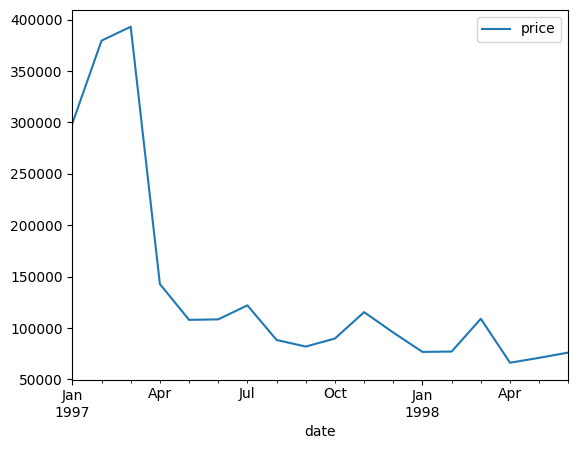

In [17]:
# .resample(rule="MS") : means groupby monthly
data.reset_index().set_index("date")[["price"]].resample(rule="MS").sum().plot()
plt.show()

### Visualize: Individual Customer Purchases

In [18]:
ids = data["customer_id"].unique()
ids

array([    1,     2,     3, ..., 23568, 23569, 23570])

In [19]:
selected_ids = ids[:10]
selected_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [20]:
# filter all the data whose customer_id belongs from 1 to 10
data[data["customer_id"].isin(selected_ids)]

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
5,3,1997-04-02,2,19.54
6,3,1997-11-15,5,57.45
7,3,1997-11-25,4,20.96
8,3,1998-05-28,1,16.99
9,4,1997-01-01,2,29.33


In [21]:
# filter all the data whose customer_id belongs from 1 to 10
subset_of_data = data[data["customer_id"].isin(selected_ids)].groupby(["customer_id","date"]).sum().reset_index()
subset_of_data

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,6,89.00
2,3,1997-01-02,2,20.76
3,3,1997-03-30,2,20.76
4,3,1997-04-02,2,19.54
5,3,1997-11-15,5,57.45
6,3,1997-11-25,4,20.96
7,3,1998-05-28,1,16.99
8,4,1997-01-01,2,29.33
9,4,1997-01-18,2,29.73


# Machine Learning
Frame the problem
1. **How much the customer will spend in next 90 days?** `Regression`
2. **What is the probability that the customer will make purchase in next 90-days?** `Classification`

## Step1: `Time Splitting`

In [22]:
n_days = 90
max_date = data["date"].max()
print(max_date)

1998-06-30 00:00:00


### Subtract n_days from the last (max) date

In [23]:
cutoff = max_date - pd.to_timedelta(n_days,unit="d")
cutoff

Timestamp('1998-04-01 00:00:00')

In [24]:
# data less than cutoff date
data_in = data[data["date"] < cutoff]
print(data_in.date.max())

# data greater than cutoff date
data_out = data[data["date"] > cutoff]
print(data_out.date.min())

1998-03-31 00:00:00
1998-04-02 00:00:00


## Step2: `Feature Engineering: RFM`

### Make target feature from data_out

In [25]:
# customers that made purchases in next 90 days
targets_df = data_out.drop("quantity",axis=1).groupby("customer_id").sum().rename({"price":"spend_90_total"},axis=1).assign(spend_90_flag=1)

/var/folders/61/l2cgm0251bd792ws429rg7ww0000gn/T/ipykernel_2128/2801169195.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [26]:
targets_df.head()

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1


### Make Recency (Date) Features from data_in

In [27]:
max_date = data_in["date"].max()
max_date

Timestamp('1998-03-31 00:00:00')

In [28]:
# extracting recency from data_in
recency_features_df = data_in[["customer_id","date"]].groupby("customer_id").apply(
    lambda x: (x["date"].max() - max_date) / pd.to_timedelta(1,"day")
).to_frame().set_axis(["recency"],axis=1)

In [29]:
recency_features_df

,recency
customer_id,
1,-454.0
2,-443.0
3,-126.0
4,-109.0
5,-87.0
...,...
23566,-371.0
23567,-371.0
23568,-343.0


### Make Freaquency (Count) Feature from data_in

In [30]:
frequency_feature_df = data_in[["customer_id","date"]].groupby("customer_id").count().set_axis(["frequency"],axis=1)

In [31]:
frequency_feature_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


### Make Monetary (Price( Feature from data_in

In [32]:
# extracting "price_sum","price_mean" from data_in
monetary_features_df = data_in.groupby("customer_id").aggregate({"price":["sum","mean"]}).set_axis(["price_sum","price_mean"],axis=1)

In [33]:
monetary_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


## Step3: `Combine Extracted (Engineered Features)`

In [34]:
features_df = pd.concat([recency_features_df,frequency_feature_df,monetary_features_df],axis=1).merge(
    targets_df, left_index=True,right_index=True,how="left"
    
).fillna(0)

In [35]:
features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-454.0,1,11.77,11.770000,0.00,0.0
2,-443.0,2,89.00,44.500000,0.00,0.0
3,-126.0,5,139.47,27.894000,16.99,1.0
4,-109.0,4,100.50,25.125000,0.00,0.0
5,-87.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-371.0,1,36.00,36.000000,0.00,0.0
23567,-371.0,1,20.97,20.970000,0.00,0.0
23568,-343.0,3,121.70,40.566667,0.00,0.0


## Step4: `Modelling`

### `Regression`: How much the customer will spend in next 90 days?

In [36]:
# split data
X = features_df[["recency","frequency","price_sum","price_mean"]]
y = features_df["spend_90_total"]

In [37]:
# model object
model = xgboost.XGBRegressor(objective="reg:squarederror",random_state=11)

In [38]:
model_grid_searh_cv = model_selection.GridSearchCV(
    model,
    param_grid=dict(
        learning_rate = [0.01,0.1,0.3,0.5]
    ),
    scoring = "neg_mean_absolute_error",
    refit = True,
    cv = 5
)

In [39]:
# fit
model_grid_searh_cv.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=11, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [40]:
model_grid_searh_cv.best_score_

-9.791985603560923

In [41]:
model_grid_searh_cv.best_params_

{'learning_rate': 0.01}

In [42]:
model_grid_searh_cv.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=11, ...)

In [43]:
model_grid_searh_cv.predict(X)

array([0.76508164, 1.7681931 , 9.107678  , ..., 3.2357693 , 0.8681409 ,
       2.159005  ], dtype=float32)

###  `Classification`: What is the probability that the customer will make purchase in next 90-days?

In [44]:
X = X.copy(deep=True)
y = features_df.spend_90_flag

In [45]:
# model object
model = xgboost.XGBClassifier(
    objective="binary:logistic",
    random_state = 11
)

In [46]:
model_grid_search_cv = model_selection.GridSearchCV(
    model,
    param_grid= dict(
        learning_rate = [0.01,0.1,0.3,0.5]
    ),
    scoring = "roc_auc",
    refit = True,
    cv = 5

)

In [47]:
# fit
model_grid_search_cv.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=11, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [48]:
model_grid_search_cv.best_score_

0.8355789541733352

In [49]:
model_grid_search_cv.best_params_

{'learning_rate': 0.01}

In [50]:
model_grid_search_cv.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=11, ...)

In [53]:
# probability
model_grid_search_cv.predict_proba(X)

array([[0.79941535, 0.20058466],
       [0.7898111 , 0.21018894],
       [0.6575636 , 0.34243637],
       ...,
       [0.7622959 , 0.2377041 ],
       [0.7955656 , 0.20443438],
       [0.77584255, 0.22415742]], dtype=float32)